In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=SETYOURDEVICEHERE
import os, sys, time
sys.path.insert(0, '..')
import lib

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)

import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'

experiment_name = 'imagenet_nashlepka_layer4_editable_SGD_momentum_match_rank'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:6])
print(experiment_name)

imagenet_nashlepka_layer4_editable_SGD_momentum_match_rank_2019.09.24_17:00:13


In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

data_path = '../../imagenet/'
logits_path = 'imagenet_logits/'

traindir = os.path.join(data_path, 'train')
valdir = os.path.join(data_path, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset = lib.ImageAndLogitsFolder(
    traindir,
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]),
    logits_prefix = logits_path
)

batch_size = 128

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=12, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=32, pin_memory=True)

X_test, y_test = map(torch.cat, zip(*val_loader))
X_test, y_test = X_test[::10], y_test[::10] 
# Note: we use 10% of data for early stopping
# We evaluate on all data later

In [4]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)

optimizer = lib.IngraphRMSProp(learning_rate=1e-4, beta=nn.Parameter(torch.as_tensor(0.5)))

model = lib.SequentialWithEditable(
    model.conv1, model.bn1, model.relu, model.maxpool,
    model.layer1, model.layer2, model.layer3, model.layer4,
    model.avgpool, lib.Flatten(),
    lib.Editable(
        lib.Residual(nn.Linear(512, 4096), nn.ELU(), nn.Linear(4096, 512)),
        loss_function=lib.contrastive_cross_entropy, 
        optimizer=optimizer, max_steps=10),

    model.fc
).to(device)

In [5]:
class EditableMatchRankTrainer(lib.DistillationEditableTrainer):
    def __init__(self, distribution_cumsum, **kwargs):
        super().__init__(**kwargs)
        self.cumsum = distribution_cumsum
    
    def train_on_batch(self, x_batch, y_batch, x_edit, y_edit, **kwargs):
        with torch.no_grad(), lib.training_mode(self.model, is_train=False):
            logits = self.model(x_edit)
            sorted_ans = logits.topk(k=logits.shape[1], dim=1).indices
            choices = (torch.rand(sorted_ans.shape[0]).view(-1, 1) > self.cumsum).to(torch.int32).sum(-1)
            choices = choices.to(sorted_ans.device)
            y_edit = sorted_ans.gather(dim=1, index=choices.view(-1, 1)).view(-1)
        super().train_on_batch(x_batch, y_batch, x_edit, y_edit, **kwargs)
        
    def evaluate_metrics(self, X, y, X_edit=None, y_edit=None, size_top=25, **kwargs):
        """
        For each sample in X_edit, y_edit attempts to train model and evaluates trained model quality
        :param X: data for quality evaluaton
        :param y: targets for quality evaluaton
        :param X_edit: sequence of data for training model on
        :param y_edit: sequence of targets for training model on
        :param kwargs: extra parameters for error function
        :return: dictionary of metrics
        """
        assert (X_edit is None) == (y_edit is None), "provide either both X_edit and y_edit or none of them"
        if X_edit is None:
            num_classes = y.max() + 1
            ind = np.random.permutation(len(X))[:10]
            X_edit = X[ind]
            with torch.no_grad(), lib.training_mode(self.model, is_train=False):
                logits = self.model(X_edit)
                sorted_ans = logits.topk(k=logits.shape[1], dim=1).indices
                choices = (torch.rand(sorted_ans.shape[0]).view(-1, 1) > self.cumsum).to(torch.int32).sum(-1)
                choices = choices.to(sorted_ans.device)
                y_edit = sorted_ans.gather(dim=1, index=choices.view(-1, 1)).view(-1)
        return super().evaluate_metrics(X, y, X_edit, y_edit, **kwargs)

In [6]:
def classification_error(model, X_test, y_test):
    with lib.training_mode(model, is_train=False):
        return lib.classification_error(lib.Lambda(lambda x: model(x.to(device))),
                                        X_test, y_test, device='cpu', batch_size=128)

## Read natural adversarial examples

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_transform = transforms.Compose(
    [transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean, std)])

thousand_k_to_200 = {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1, 10: -1, 11: 1, 12: -1, 13: 2, 14: -1, 15: 3, 16: -1, 17: 4, 18: -1, 19: -1, 20: -1, 21: -1, 22: 5, 23: 6, 24: -1, 25: -1, 26: -1, 27: 7, 28: -1, 29: -1, 30: 8, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: 9, 38: -1, 39: 10, 40: -1, 41: -1, 42: 11, 43: -1, 44: -1, 45: -1, 46: -1, 47: 12, 48: -1, 49: -1, 50: 13, 51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: 14, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: 15, 71: 16, 72: -1, 73: -1, 74: -1, 75: -1, 76: 17, 77: -1, 78: -1, 79: 18, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: 19, 90: 20, 91: -1, 92: -1, 93: -1, 94: 21, 95: -1, 96: 22, 97: 23, 98: -1, 99: 24, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: 25, 106: -1, 107: 26, 108: 27, 109: -1, 110: 28, 111: -1, 112: -1, 113: 29, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: 30, 125: 31, 126: -1, 127: -1, 128: -1, 129: -1, 130: 32, 131: -1, 132: 33, 133: -1, 134: -1, 135: -1, 136: -1, 137: -1, 138: -1, 139: -1, 140: -1, 141: -1, 142: -1, 143: 34, 144: 35, 145: -1, 146: -1, 147: -1, 148: -1, 149: -1, 150: 36, 151: 37, 152: -1, 153: -1, 154: -1, 155: -1, 156: -1, 157: -1, 158: -1, 159: -1, 160: -1, 161: -1, 162: -1, 163: -1, 164: -1, 165: -1, 166: -1, 167: -1, 168: -1, 169: -1, 170: -1, 171: -1, 172: -1, 173: -1, 174: -1, 175: -1, 176: -1, 177: -1, 178: -1, 179: -1, 180: -1, 181: -1, 182: -1, 183: -1, 184: -1, 185: -1, 186: -1, 187: -1, 188: -1, 189: -1, 190: -1, 191: -1, 192: -1, 193: -1, 194: -1, 195: -1, 196: -1, 197: -1, 198: -1, 199: -1, 200: -1, 201: -1, 202: -1, 203: -1, 204: -1, 205: -1, 206: -1, 207: 38, 208: -1, 209: -1, 210: -1, 211: -1, 212: -1, 213: -1, 214: -1, 215: -1, 216: -1, 217: -1, 218: -1, 219: -1, 220: -1, 221: -1, 222: -1, 223: -1, 224: -1, 225: -1, 226: -1, 227: -1, 228: -1, 229: -1, 230: -1, 231: -1, 232: -1, 233: -1, 234: 39, 235: 40, 236: -1, 237: -1, 238: -1, 239: -1, 240: -1, 241: -1, 242: -1, 243: -1, 244: -1, 245: -1, 246: -1, 247: -1, 248: -1, 249: -1, 250: -1, 251: -1, 252: -1, 253: -1, 254: 41, 255: -1, 256: -1, 257: -1, 258: -1, 259: -1, 260: -1, 261: -1, 262: -1, 263: -1, 264: -1, 265: -1, 266: -1, 267: -1, 268: -1, 269: -1, 270: -1, 271: -1, 272: -1, 273: -1, 274: -1, 275: -1, 276: -1, 277: 42, 278: -1, 279: -1, 280: -1, 281: -1, 282: -1, 283: 43, 284: -1, 285: -1, 286: -1, 287: 44, 288: -1, 289: -1, 290: -1, 291: 45, 292: -1, 293: -1, 294: -1, 295: 46, 296: -1, 297: -1, 298: 47, 299: -1, 300: -1, 301: 48, 302: -1, 303: -1, 304: -1, 305: -1, 306: 49, 307: 50, 308: 51, 309: 52, 310: 53, 311: 54, 312: -1, 313: 55, 314: 56, 315: 57, 316: -1, 317: 58, 318: -1, 319: 59, 320: -1, 321: -1, 322: -1, 323: 60, 324: 61, 325: -1, 326: 62, 327: 63, 328: -1, 329: -1, 330: 64, 331: -1, 332: -1, 333: -1, 334: 65, 335: 66, 336: 67, 337: -1, 338: -1, 339: -1, 340: -1, 341: -1, 342: -1, 343: -1, 344: -1, 345: -1, 346: -1, 347: 68, 348: -1, 349: -1, 350: -1, 351: -1, 352: -1, 353: -1, 354: -1, 355: -1, 356: -1, 357: -1, 358: -1, 359: -1, 360: -1, 361: 69, 362: -1, 363: 70, 364: -1, 365: -1, 366: -1, 367: -1, 368: -1, 369: -1, 370: -1, 371: -1, 372: 71, 373: -1, 374: -1, 375: -1, 376: -1, 377: -1, 378: 72, 379: -1, 380: -1, 381: -1, 382: -1, 383: -1, 384: -1, 385: -1, 386: 73, 387: -1, 388: -1, 389: -1, 390: -1, 391: -1, 392: -1, 393: -1, 394: -1, 395: -1, 396: -1, 397: 74, 398: -1, 399: -1, 400: 75, 401: 76, 402: 77, 403: -1, 404: 78, 405: -1, 406: -1, 407: 79, 408: -1, 409: -1, 410: -1, 411: 80, 412: -1, 413: -1, 414: -1, 415: -1, 416: 81, 417: 82, 418: -1, 419: -1, 420: 83, 421: -1, 422: -1, 423: -1, 424: -1, 425: 84, 426: -1, 427: -1, 428: 85, 429: -1, 430: 86, 431: -1, 432: -1, 433: -1, 434: -1, 435: -1, 436: -1, 437: 87, 438: 88, 439: -1, 440: -1, 441: -1, 442: -1, 443: -1, 444: -1, 445: 89, 446: -1, 447: -1, 448: -1, 449: -1, 450: -1, 451: -1, 452: -1, 453: -1, 454: -1, 455: -1, 456: 90, 457: 91, 458: -1, 459: -1, 460: -1, 461: 92, 462: 93, 463: -1, 464: -1, 465: -1, 466: -1, 467: -1, 468: -1, 469: -1, 470: 94, 471: -1, 472: 95, 473: -1, 474: -1, 475: -1, 476: -1, 477: -1, 478: -1, 479: -1, 480: -1, 481: -1, 482: -1, 483: 96, 484: -1, 485: -1, 486: 97, 487: -1, 488: 98, 489: -1, 490: -1, 491: -1, 492: 99, 493: -1, 494: -1, 495: -1, 496: 100, 497: -1, 498: -1, 499: -1, 500: -1, 501: -1, 502: -1, 503: -1, 504: -1, 505: -1, 506: -1, 507: -1, 508: -1, 509: -1, 510: -1, 511: -1, 512: -1, 513: -1, 514: 101, 515: -1, 516: 102, 517: -1, 518: -1, 519: -1, 520: -1, 521: -1, 522: -1, 523: -1, 524: -1, 525: -1, 526: -1, 527: -1, 528: 103, 529: -1, 530: 104, 531: -1, 532: -1, 533: -1, 534: -1, 535: -1, 536: -1, 537: -1, 538: -1, 539: 105, 540: -1, 541: -1, 542: 106, 543: 107, 544: -1, 545: -1, 546: -1, 547: -1, 548: -1, 549: 108, 550: -1, 551: -1, 552: 109, 553: -1, 554: -1, 555: -1, 556: -1, 557: 110, 558: -1, 559: -1, 560: -1, 561: 111, 562: 112, 563: -1, 564: -1, 565: -1, 566: -1, 567: -1, 568: -1, 569: 113, 570: -1, 571: -1, 572: 114, 573: 115, 574: -1, 575: 116, 576: -1, 577: -1, 578: -1, 579: 117, 580: -1, 581: -1, 582: -1, 583: -1, 584: -1, 585: -1, 586: -1, 587: -1, 588: -1, 589: 118, 590: -1, 591: -1, 592: -1, 593: -1, 594: -1, 595: -1, 596: -1, 597: -1, 598: -1, 599: -1, 600: -1, 601: -1, 602: -1, 603: -1, 604: -1, 605: -1, 606: 119, 607: 120, 608: -1, 609: 121, 610: -1, 611: -1, 612: -1, 613: -1, 614: 122, 615: -1, 616: -1, 617: -1, 618: -1, 619: -1, 620: -1, 621: -1, 622: -1, 623: -1, 624: -1, 625: -1, 626: 123, 627: 124, 628: -1, 629: -1, 630: -1, 631: -1, 632: -1, 633: -1, 634: -1, 635: -1, 636: -1, 637: -1, 638: -1, 639: -1, 640: 125, 641: 126, 642: 127, 643: 128, 644: -1, 645: -1, 646: -1, 647: -1, 648: -1, 649: -1, 650: -1, 651: -1, 652: -1, 653: -1, 654: -1, 655: -1, 656: -1, 657: -1, 658: 129, 659: -1, 660: -1, 661: -1, 662: -1, 663: -1, 664: -1, 665: -1, 666: -1, 667: -1, 668: 130, 669: -1, 670: -1, 671: -1, 672: -1, 673: -1, 674: -1, 675: -1, 676: -1, 677: 131, 678: -1, 679: -1, 680: -1, 681: -1, 682: 132, 683: -1, 684: 133, 685: -1, 686: -1, 687: 134, 688: -1, 689: -1, 690: -1, 691: -1, 692: -1, 693: -1, 694: -1, 695: -1, 696: -1, 697: -1, 698: -1, 699: -1, 700: -1, 701: 135, 702: -1, 703: -1, 704: 136, 705: -1, 706: -1, 707: -1, 708: -1, 709: -1, 710: -1, 711: -1, 712: -1, 713: -1, 714: -1, 715: -1, 716: -1, 717: -1, 718: -1, 719: 137, 720: -1, 721: -1, 722: -1, 723: -1, 724: -1, 725: -1, 726: -1, 727: -1, 728: -1, 729: -1, 730: -1, 731: -1, 732: -1, 733: -1, 734: -1, 735: -1, 736: 138, 737: -1, 738: -1, 739: -1, 740: -1, 741: -1, 742: -1, 743: -1, 744: -1, 745: -1, 746: 139, 747: -1, 748: -1, 749: 140, 750: -1, 751: -1, 752: 141, 753: -1, 754: -1, 755: -1, 756: -1, 757: -1, 758: 142, 759: -1, 760: -1, 761: -1, 762: -1, 763: 143, 764: -1, 765: 144, 766: -1, 767: -1, 768: 145, 769: -1, 770: -1, 771: -1, 772: -1, 773: 146, 774: 147, 775: -1, 776: 148, 777: -1, 778: -1, 779: 149, 780: 150, 781: -1, 782: -1, 783: -1, 784: -1, 785: -1, 786: 151, 787: -1, 788: -1, 789: -1, 790: -1, 791: -1, 792: 152, 793: -1, 794: -1, 795: -1, 796: -1, 797: 153, 798: -1, 799: -1, 800: -1, 801: -1, 802: 154, 803: 155, 804: 156, 805: -1, 806: -1, 807: -1, 808: -1, 809: -1, 810: -1, 811: -1, 812: -1, 813: 157, 814: -1, 815: 158, 816: -1, 817: -1, 818: -1, 819: -1, 820: 159, 821: -1, 822: -1, 823: 160, 824: -1, 825: -1, 826: -1, 827: -1, 828: -1, 829: -1, 830: -1, 831: 161, 832: -1, 833: 162, 834: -1, 835: 163, 836: -1, 837: -1, 838: -1, 839: 164, 840: -1, 841: -1, 842: -1, 843: -1, 844: -1, 845: 165, 846: -1, 847: 166, 848: -1, 849: -1, 850: 167, 851: -1, 852: -1, 853: -1, 854: -1, 855: -1, 856: -1, 857: -1, 858: -1, 859: 168, 860: -1, 861: -1, 862: 169, 863: -1, 864: -1, 865: -1, 866: -1, 867: -1, 868: -1, 869: -1, 870: 170, 871: -1, 872: -1, 873: -1, 874: -1, 875: -1, 876: -1, 877: -1, 878: -1, 879: 171, 880: 172, 881: -1, 882: -1, 883: -1, 884: -1, 885: -1, 886: -1, 887: -1, 888: 173, 889: -1, 890: 174, 891: -1, 892: -1, 893: -1, 894: -1, 895: -1, 896: -1, 897: 175, 898: -1, 899: -1, 900: 176, 901: -1, 902: -1, 903: -1, 904: -1, 905: -1, 906: -1, 907: 177, 908: -1, 909: -1, 910: -1, 911: -1, 912: -1, 913: 178, 914: -1, 915: -1, 916: -1, 917: -1, 918: -1, 919: -1, 920: -1, 921: -1, 922: -1, 923: -1, 924: 179, 925: -1, 926: -1, 927: -1, 928: -1, 929: -1, 930: -1, 931: -1, 932: 180, 933: 181, 934: 182, 935: -1, 936: -1, 937: 183, 938: -1, 939: -1, 940: -1, 941: -1, 942: -1, 943: 184, 944: -1, 945: 185, 946: -1, 947: 186, 948: -1, 949: -1, 950: -1, 951: 187, 952: -1, 953: -1, 954: 188, 955: -1, 956: 189, 957: 190, 958: -1, 959: 191, 960: -1, 961: -1, 962: -1, 963: -1, 964: -1, 965: -1, 966: -1, 967: -1, 968: -1, 969: -1, 970: -1, 971: 192, 972: 193, 973: -1, 974: -1, 975: -1, 976: -1, 977: -1, 978: -1, 979: -1, 980: 194, 981: 195, 982: -1, 983: -1, 984: 196, 985: -1, 986: 197, 987: 198, 988: 199, 989: -1, 990: -1, 991: -1, 992: -1, 993: -1, 994: -1, 995: -1, 996: -1, 997: -1, 998: -1, 999: -1}
two_hundred_to_1000 = dict(map(reversed, thousand_k_to_200.items()))

X_adv, y_adv = zip(*datasets.ImageFolder(root="./imagenet-a/", transform=test_transform))
X_adv = torch.stack(X_adv)
y_adv = torch.tensor(list(map(two_hundred_to_1000.get, y_adv)))

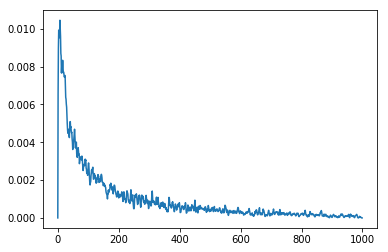

In [27]:
from scipy.signal import correlate
def calculate_natural_distribution(model, X_adv, y_adv, batch_size=256, kernel=np.array([0.1, 0.2, 0.4, 0.2, 0.1])):
    with torch.no_grad(), lib.training_mode(model, is_train=False):
        logits = lib.process_in_chunks(lambda X_batch:model(X_batch.to(device)), X_adv, batch_size=batch_size)
        sorted_ans = logits.topk(k=logits.shape[1], dim=1).indices.to('cpu')
        y_rank = (sorted_ans == y_adv.view(-1,1)).argmax(dim=1)
        bin_counts = np.bincount(lib.check_numpy(y_rank), minlength=logits.shape[-1]).astype('float32')
    soft_counts = correlate(bin_counts, kernel)[(len(kernel) - 1) // 2: (len(kernel) - 1) // 2 + len(bin_counts)]
    soft_counts[0] = 0
    assert len(soft_counts) == len(bin_counts)
    return soft_counts / soft_counts.sum()

soft_counts = calculate_natural_distribution(models.resnet18(pretrained=True).to(device), X_adv, y_adv)

plt.plot(soft_counts)

cumsum = soft_counts.cumsum() / soft_counts.sum()
cumsum = torch.as_tensor(cumsum, dtype=torch.float32)

### Train

In [8]:
new_params = set(model.editable.module[0].parameters())
old_params = [param for param in model.parameters() if param not in new_params]

training_opt = lib.OptimizerList(
    torch.optim.SGD(old_params, lr=1e-5, momentum=0.9, weight_decay=1e-4),
    torch.optim.SGD(new_params, lr=1e-3, momentum=0.9, weight_decay=1e-4),
)

trainer = EditableMatchRankTrainer(cumsum, model=model,
          stability_coeff=0.03, editability_coeff=0.03,
          experiment_name=experiment_name,
          error_function=classification_error,
          opt=training_opt, max_norm=10)

trainer.writer.add_text("trainer", repr(trainer).replace('\n', '<br>'))

In [29]:
from tqdm import tqdm_notebook, tnrange
from IPython.display import clear_output

# Learnign params
eval_batch_cd = 500
val_metrics = trainer.evaluate_metrics(X_test.to(device), y_test.to(device))
min_error, min_drawdown = val_metrics['base_error'], val_metrics['drawdown']
early_stopping_epochs = 500
number_of_epochs_without_improvement = 0
            
def edit_generator():
    while True:
        for xb, yb, lg in torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2):
            yield xb.to(device), torch.randint_like(yb, low=0, high=max(y_test) + 1, device=device)

edit_generator = edit_generator()

In [ ]:
while True:
    
    for x_batch, y_batch, logits in tqdm_notebook(train_loader):
        trainer.step(x_batch.to(device), logits.to(device), *next(edit_generator))
        
        if trainer.total_steps % eval_batch_cd == 0:
            val_metrics = trainer.evaluate_metrics(X_test.to(device), y_test.to(device))
            clear_output(True)

            error_rate, drawdown = val_metrics['base_error'], val_metrics['drawdown']

            number_of_epochs_without_improvement += 1

            if error_rate < min_error:
                trainer.save_checkpoint(tag='best_val_error')
                min_error = error_rate
                number_of_epochs_without_improvement = 0

            if drawdown < min_drawdown:
                trainer.save_checkpoint(tag='best_drawdown')
                min_drawdown = drawdown
                number_of_epochs_without_improvement = 0

            trainer.save_checkpoint()
            trainer.remove_old_temp_checkpoints()

            if number_of_epochs_without_improvement > early_stopping_epochs:
                break

### Eval metrics

In [13]:
trainer.load_checkpoint(path='best_val_error');
# if you're not running this in the same notebook, you can also select the checkpoint via path
# trainer.load_checkpoint(path='./logs/EXPERIMENTNAMEHERE/checkpoint_best_val_error.pth')

## Adv metrics

In [14]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_transform = transforms.Compose(
    [transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean, std)])

thousand_k_to_200 = {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1, 10: -1, 11: 1, 12: -1, 13: 2, 14: -1, 15: 3, 16: -1, 17: 4, 18: -1, 19: -1, 20: -1, 21: -1, 22: 5, 23: 6, 24: -1, 25: -1, 26: -1, 27: 7, 28: -1, 29: -1, 30: 8, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: 9, 38: -1, 39: 10, 40: -1, 41: -1, 42: 11, 43: -1, 44: -1, 45: -1, 46: -1, 47: 12, 48: -1, 49: -1, 50: 13, 51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: 14, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: 15, 71: 16, 72: -1, 73: -1, 74: -1, 75: -1, 76: 17, 77: -1, 78: -1, 79: 18, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: 19, 90: 20, 91: -1, 92: -1, 93: -1, 94: 21, 95: -1, 96: 22, 97: 23, 98: -1, 99: 24, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: 25, 106: -1, 107: 26, 108: 27, 109: -1, 110: 28, 111: -1, 112: -1, 113: 29, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: 30, 125: 31, 126: -1, 127: -1, 128: -1, 129: -1, 130: 32, 131: -1, 132: 33, 133: -1, 134: -1, 135: -1, 136: -1, 137: -1, 138: -1, 139: -1, 140: -1, 141: -1, 142: -1, 143: 34, 144: 35, 145: -1, 146: -1, 147: -1, 148: -1, 149: -1, 150: 36, 151: 37, 152: -1, 153: -1, 154: -1, 155: -1, 156: -1, 157: -1, 158: -1, 159: -1, 160: -1, 161: -1, 162: -1, 163: -1, 164: -1, 165: -1, 166: -1, 167: -1, 168: -1, 169: -1, 170: -1, 171: -1, 172: -1, 173: -1, 174: -1, 175: -1, 176: -1, 177: -1, 178: -1, 179: -1, 180: -1, 181: -1, 182: -1, 183: -1, 184: -1, 185: -1, 186: -1, 187: -1, 188: -1, 189: -1, 190: -1, 191: -1, 192: -1, 193: -1, 194: -1, 195: -1, 196: -1, 197: -1, 198: -1, 199: -1, 200: -1, 201: -1, 202: -1, 203: -1, 204: -1, 205: -1, 206: -1, 207: 38, 208: -1, 209: -1, 210: -1, 211: -1, 212: -1, 213: -1, 214: -1, 215: -1, 216: -1, 217: -1, 218: -1, 219: -1, 220: -1, 221: -1, 222: -1, 223: -1, 224: -1, 225: -1, 226: -1, 227: -1, 228: -1, 229: -1, 230: -1, 231: -1, 232: -1, 233: -1, 234: 39, 235: 40, 236: -1, 237: -1, 238: -1, 239: -1, 240: -1, 241: -1, 242: -1, 243: -1, 244: -1, 245: -1, 246: -1, 247: -1, 248: -1, 249: -1, 250: -1, 251: -1, 252: -1, 253: -1, 254: 41, 255: -1, 256: -1, 257: -1, 258: -1, 259: -1, 260: -1, 261: -1, 262: -1, 263: -1, 264: -1, 265: -1, 266: -1, 267: -1, 268: -1, 269: -1, 270: -1, 271: -1, 272: -1, 273: -1, 274: -1, 275: -1, 276: -1, 277: 42, 278: -1, 279: -1, 280: -1, 281: -1, 282: -1, 283: 43, 284: -1, 285: -1, 286: -1, 287: 44, 288: -1, 289: -1, 290: -1, 291: 45, 292: -1, 293: -1, 294: -1, 295: 46, 296: -1, 297: -1, 298: 47, 299: -1, 300: -1, 301: 48, 302: -1, 303: -1, 304: -1, 305: -1, 306: 49, 307: 50, 308: 51, 309: 52, 310: 53, 311: 54, 312: -1, 313: 55, 314: 56, 315: 57, 316: -1, 317: 58, 318: -1, 319: 59, 320: -1, 321: -1, 322: -1, 323: 60, 324: 61, 325: -1, 326: 62, 327: 63, 328: -1, 329: -1, 330: 64, 331: -1, 332: -1, 333: -1, 334: 65, 335: 66, 336: 67, 337: -1, 338: -1, 339: -1, 340: -1, 341: -1, 342: -1, 343: -1, 344: -1, 345: -1, 346: -1, 347: 68, 348: -1, 349: -1, 350: -1, 351: -1, 352: -1, 353: -1, 354: -1, 355: -1, 356: -1, 357: -1, 358: -1, 359: -1, 360: -1, 361: 69, 362: -1, 363: 70, 364: -1, 365: -1, 366: -1, 367: -1, 368: -1, 369: -1, 370: -1, 371: -1, 372: 71, 373: -1, 374: -1, 375: -1, 376: -1, 377: -1, 378: 72, 379: -1, 380: -1, 381: -1, 382: -1, 383: -1, 384: -1, 385: -1, 386: 73, 387: -1, 388: -1, 389: -1, 390: -1, 391: -1, 392: -1, 393: -1, 394: -1, 395: -1, 396: -1, 397: 74, 398: -1, 399: -1, 400: 75, 401: 76, 402: 77, 403: -1, 404: 78, 405: -1, 406: -1, 407: 79, 408: -1, 409: -1, 410: -1, 411: 80, 412: -1, 413: -1, 414: -1, 415: -1, 416: 81, 417: 82, 418: -1, 419: -1, 420: 83, 421: -1, 422: -1, 423: -1, 424: -1, 425: 84, 426: -1, 427: -1, 428: 85, 429: -1, 430: 86, 431: -1, 432: -1, 433: -1, 434: -1, 435: -1, 436: -1, 437: 87, 438: 88, 439: -1, 440: -1, 441: -1, 442: -1, 443: -1, 444: -1, 445: 89, 446: -1, 447: -1, 448: -1, 449: -1, 450: -1, 451: -1, 452: -1, 453: -1, 454: -1, 455: -1, 456: 90, 457: 91, 458: -1, 459: -1, 460: -1, 461: 92, 462: 93, 463: -1, 464: -1, 465: -1, 466: -1, 467: -1, 468: -1, 469: -1, 470: 94, 471: -1, 472: 95, 473: -1, 474: -1, 475: -1, 476: -1, 477: -1, 478: -1, 479: -1, 480: -1, 481: -1, 482: -1, 483: 96, 484: -1, 485: -1, 486: 97, 487: -1, 488: 98, 489: -1, 490: -1, 491: -1, 492: 99, 493: -1, 494: -1, 495: -1, 496: 100, 497: -1, 498: -1, 499: -1, 500: -1, 501: -1, 502: -1, 503: -1, 504: -1, 505: -1, 506: -1, 507: -1, 508: -1, 509: -1, 510: -1, 511: -1, 512: -1, 513: -1, 514: 101, 515: -1, 516: 102, 517: -1, 518: -1, 519: -1, 520: -1, 521: -1, 522: -1, 523: -1, 524: -1, 525: -1, 526: -1, 527: -1, 528: 103, 529: -1, 530: 104, 531: -1, 532: -1, 533: -1, 534: -1, 535: -1, 536: -1, 537: -1, 538: -1, 539: 105, 540: -1, 541: -1, 542: 106, 543: 107, 544: -1, 545: -1, 546: -1, 547: -1, 548: -1, 549: 108, 550: -1, 551: -1, 552: 109, 553: -1, 554: -1, 555: -1, 556: -1, 557: 110, 558: -1, 559: -1, 560: -1, 561: 111, 562: 112, 563: -1, 564: -1, 565: -1, 566: -1, 567: -1, 568: -1, 569: 113, 570: -1, 571: -1, 572: 114, 573: 115, 574: -1, 575: 116, 576: -1, 577: -1, 578: -1, 579: 117, 580: -1, 581: -1, 582: -1, 583: -1, 584: -1, 585: -1, 586: -1, 587: -1, 588: -1, 589: 118, 590: -1, 591: -1, 592: -1, 593: -1, 594: -1, 595: -1, 596: -1, 597: -1, 598: -1, 599: -1, 600: -1, 601: -1, 602: -1, 603: -1, 604: -1, 605: -1, 606: 119, 607: 120, 608: -1, 609: 121, 610: -1, 611: -1, 612: -1, 613: -1, 614: 122, 615: -1, 616: -1, 617: -1, 618: -1, 619: -1, 620: -1, 621: -1, 622: -1, 623: -1, 624: -1, 625: -1, 626: 123, 627: 124, 628: -1, 629: -1, 630: -1, 631: -1, 632: -1, 633: -1, 634: -1, 635: -1, 636: -1, 637: -1, 638: -1, 639: -1, 640: 125, 641: 126, 642: 127, 643: 128, 644: -1, 645: -1, 646: -1, 647: -1, 648: -1, 649: -1, 650: -1, 651: -1, 652: -1, 653: -1, 654: -1, 655: -1, 656: -1, 657: -1, 658: 129, 659: -1, 660: -1, 661: -1, 662: -1, 663: -1, 664: -1, 665: -1, 666: -1, 667: -1, 668: 130, 669: -1, 670: -1, 671: -1, 672: -1, 673: -1, 674: -1, 675: -1, 676: -1, 677: 131, 678: -1, 679: -1, 680: -1, 681: -1, 682: 132, 683: -1, 684: 133, 685: -1, 686: -1, 687: 134, 688: -1, 689: -1, 690: -1, 691: -1, 692: -1, 693: -1, 694: -1, 695: -1, 696: -1, 697: -1, 698: -1, 699: -1, 700: -1, 701: 135, 702: -1, 703: -1, 704: 136, 705: -1, 706: -1, 707: -1, 708: -1, 709: -1, 710: -1, 711: -1, 712: -1, 713: -1, 714: -1, 715: -1, 716: -1, 717: -1, 718: -1, 719: 137, 720: -1, 721: -1, 722: -1, 723: -1, 724: -1, 725: -1, 726: -1, 727: -1, 728: -1, 729: -1, 730: -1, 731: -1, 732: -1, 733: -1, 734: -1, 735: -1, 736: 138, 737: -1, 738: -1, 739: -1, 740: -1, 741: -1, 742: -1, 743: -1, 744: -1, 745: -1, 746: 139, 747: -1, 748: -1, 749: 140, 750: -1, 751: -1, 752: 141, 753: -1, 754: -1, 755: -1, 756: -1, 757: -1, 758: 142, 759: -1, 760: -1, 761: -1, 762: -1, 763: 143, 764: -1, 765: 144, 766: -1, 767: -1, 768: 145, 769: -1, 770: -1, 771: -1, 772: -1, 773: 146, 774: 147, 775: -1, 776: 148, 777: -1, 778: -1, 779: 149, 780: 150, 781: -1, 782: -1, 783: -1, 784: -1, 785: -1, 786: 151, 787: -1, 788: -1, 789: -1, 790: -1, 791: -1, 792: 152, 793: -1, 794: -1, 795: -1, 796: -1, 797: 153, 798: -1, 799: -1, 800: -1, 801: -1, 802: 154, 803: 155, 804: 156, 805: -1, 806: -1, 807: -1, 808: -1, 809: -1, 810: -1, 811: -1, 812: -1, 813: 157, 814: -1, 815: 158, 816: -1, 817: -1, 818: -1, 819: -1, 820: 159, 821: -1, 822: -1, 823: 160, 824: -1, 825: -1, 826: -1, 827: -1, 828: -1, 829: -1, 830: -1, 831: 161, 832: -1, 833: 162, 834: -1, 835: 163, 836: -1, 837: -1, 838: -1, 839: 164, 840: -1, 841: -1, 842: -1, 843: -1, 844: -1, 845: 165, 846: -1, 847: 166, 848: -1, 849: -1, 850: 167, 851: -1, 852: -1, 853: -1, 854: -1, 855: -1, 856: -1, 857: -1, 858: -1, 859: 168, 860: -1, 861: -1, 862: 169, 863: -1, 864: -1, 865: -1, 866: -1, 867: -1, 868: -1, 869: -1, 870: 170, 871: -1, 872: -1, 873: -1, 874: -1, 875: -1, 876: -1, 877: -1, 878: -1, 879: 171, 880: 172, 881: -1, 882: -1, 883: -1, 884: -1, 885: -1, 886: -1, 887: -1, 888: 173, 889: -1, 890: 174, 891: -1, 892: -1, 893: -1, 894: -1, 895: -1, 896: -1, 897: 175, 898: -1, 899: -1, 900: 176, 901: -1, 902: -1, 903: -1, 904: -1, 905: -1, 906: -1, 907: 177, 908: -1, 909: -1, 910: -1, 911: -1, 912: -1, 913: 178, 914: -1, 915: -1, 916: -1, 917: -1, 918: -1, 919: -1, 920: -1, 921: -1, 922: -1, 923: -1, 924: 179, 925: -1, 926: -1, 927: -1, 928: -1, 929: -1, 930: -1, 931: -1, 932: 180, 933: 181, 934: 182, 935: -1, 936: -1, 937: 183, 938: -1, 939: -1, 940: -1, 941: -1, 942: -1, 943: 184, 944: -1, 945: 185, 946: -1, 947: 186, 948: -1, 949: -1, 950: -1, 951: 187, 952: -1, 953: -1, 954: 188, 955: -1, 956: 189, 957: 190, 958: -1, 959: 191, 960: -1, 961: -1, 962: -1, 963: -1, 964: -1, 965: -1, 966: -1, 967: -1, 968: -1, 969: -1, 970: -1, 971: 192, 972: 193, 973: -1, 974: -1, 975: -1, 976: -1, 977: -1, 978: -1, 979: -1, 980: 194, 981: 195, 982: -1, 983: -1, 984: 196, 985: -1, 986: 197, 987: 198, 988: 199, 989: -1, 990: -1, 991: -1, 992: -1, 993: -1, 994: -1, 995: -1, 996: -1, 997: -1, 998: -1, 999: -1}
two_hundred_to_1000 = dict(map(reversed, thousand_k_to_200.items()))

X_adv, y_adv = zip(*datasets.ImageFolder(root="./imagenet-a/", transform=test_transform))
X_adv = torch.stack(X_adv)
y_adv = torch.tensor(list(map(two_hundred_to_1000.get, y_adv)))

X_test, y_test = map(torch.cat, zip(*val_loader))  # Read the whole test

In [25]:
from lib import evaluate_quality
from tqdm import tqdm_notebook

np.random.seed(9)
indices = np.random.permutation(len(X_adv))[:1000]
X_edit = X_adv[indices].cuda()
y_edit = y_adv[indices].cuda()
metrics_adv = evaluate_quality(model, X_test, y_test, X_edit, y_edit, 
                           error_function=classification_error, progressbar=tqdm_notebook)

for key in sorted(metrics_adv.keys()):
    print('{}\t:{:.5}'.format(key, metrics_adv[key]))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

base_error	:0.30764
drawdown	:0.0014556
mean_complexity	:2.149
success_rate	:1.0
